#Unet

The following cells create a class called Unet, responsible for holding the CNN model, which will be used to classify the images.

In [ ]:
# Import necessary libraries
from keras.models import Model
from keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, 
    Conv2DTranspose, Dropout, BatchNormalization, UpSampling2D, Lambda)
import tensorflow as tf

In [ ]:
# Creates class
class Unet:
    def __init__(self, outchns=1):
        self.outchns = outchns
        self.model = self.build()
        
    def loadWeights(self, pathToWeights):
        try:
            self.model.load_weights(pathToWeights)
        except:
            print(pathToWeights, 'cannot be loaded')
        
    def build(self):

        # Defines the input that the model will take
        # This is ususally the dimensions of the image
        inputs = Input((160, 160, 3))

        # Sets a list of convolutions and pooling.
        # Check the following article for a better understanding
        # https://towardsdatascience.com/understanding-convolutions-and-pooling-in-neural-networks-a-simple-explanation-885a2d78f211
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Dropout(0.2)(conv5)
        
        up6 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
        conv6 = BatchNormalization()(conv6)
        
        up7 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
        conv7 = BatchNormalization()(conv7)
        
        up8 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
        conv8 = BatchNormalization()(conv8)
        
        up9 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
        conv9 = BatchNormalization()(conv9)
        
        conv10 = Conv2D(self.outchns, (1, 1), activation='sigmoid')(conv9)

        model = Model(inputs=[inputs], outputs=[conv10])

        return model

#Config file

This part of the code set the parameters to be used in other pieces of the code. The parameters are: Batch size, image resolution, number of epochs, data augmentation parameters for training and validation set.

In [ ]:
import albumentations as A

class config:
  BATCH_SIZE = 30
  IMG_SIZE = 160

  CLASSES = 1  # number of output channels

  EPOCHS = 50

  # The following is used to augment the images of the dataset
  AUGMENTER_TRAIN = A.Compose(
      transforms=[
          A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1.0),
          # A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1.0),
          A.Transpose(p=0.5),
          A.VerticalFlip(p=0.5),
          A.HorizontalFlip(p=0.5),
      ],
  )

  AUGMENTER_VAL = A.Compose(
      transforms=[
          A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1.0),
          # A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1.0),
      ],
  )

#Dataset

Here, we are creating function that will split the data between training and testing sets, as well as implementing the data augmentation to our dataset.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import Iterator


def random_image_and_mask(config):
    S = config.IMG_SIZE
    img = np.zeros(shape=(S, S, 3), dtype=np.uint8)
    mask = np.zeros(shape=(S, S, config.CLASSES), dtype=np.uint8)

    # Random color for img
    img += np.random.randint(0, 255, size=(3,), dtype=np.uint8)

    # Add a random box
    w, h = np.random.randint(int(S * 0.1), int(S * 0.3), size=(2,))
    box_color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
    x, y = np.random.randint(0, int(S * 0.9), size=(2,))
    img[y:y+h, x:x+w, :] = box_color
    mask[y:y+h, x:x+w, :] = 255

    return img, mask


class IteratorWithAug(Iterator):
    """ Iterator that generate data from directory and a list of images and a
        corresponding list of class labels
    """

    def __init__(self,
                 image_paths,
                 mask_paths,
                 config,
                 augmenter=None,
                 mode=None,
                 shuffle=True,
                 batch_size=16,
                 seed=None,
                 ):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n = len(image_paths)
        #assert self.n == len(mask_paths)
        self.batch_size = batch_size
        self.mode = mode
        self.config = config
        self.augmenter = augmenter

        super().__init__(self.n,
                         batch_size,
                         shuffle,
                         seed=seed)

    def _get_batches_of_transformed_samples(self, index_array):
        # build batch of image & gt
        batch_x = []
        batch_y = []
        for i, j in enumerate(index_array):
            # TODO: read rgb from: self.image_paths[j]
            # TODO: read bw mask from: self.mask_paths[j]
            rgb, bw = random_image_and_mask(self.config)

            # Run Augmentation
            if self.augmenter is not None:
                transformed = self.augmenter(image=rgb, mask=bw, keypoints=[])
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            else:
                transformed_image = rgb
                transformed_mask = bw

            if len(transformed_mask.shape) == 2:
                transformed_mask = transformed_mask[..., np.newaxis]

            batch_x.append(transformed_image)
            batch_y.append(transformed_mask)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        # standardize
        batch_x = (batch_x.astype(np.float32) / 255) - 0.5
        batch_y = (batch_y > 127).astype(np.float32)

        return batch_x, batch_y

# Train

With all the functions declared and parameters set, we can train the CNN model on the dataset.

In [ ]:
# COLAB ONLY: Check for GPU environment
!nvidia-smi

Sat Jun 11 14:09:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as K

In [ ]:
# Function to calculate the jaccard distance:
# https://opensourcebiology.eu/2021/09/22/how-to-understand-this-jaccard-distance/
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
# Set up datasets (currently dummy data)
x_train = [''] * 10000  # TODO: not used for this demo of random images... Later, set to file paths
y_train = [''] * 10000  # TODO: not used for this demo of random images... Later, set to file paths
x_val = [''] * 100  # TODO: not used for this demo of random images... Later, set to file paths
y_val = [''] * 100  # TODO: not used for this demo of random images... Later, set to file path

This dataset is made of emptty strings and it is only used to test the code's execution. When using real data, the varibles need to be set to a directory path, like:

In [ ]:
# Set up datasets (sample)
x_train = 'data/Training_Input'
y_train = 'data/Training_GroundTruth/pigment_network'
x_val = 'data/Validation_Input' 
y_val = 'data/Validation_GroundTruth/pigment_network' 

In [ ]:
# Used to apply data augmentation to the data
train_generator = IteratorWithAug(
    image_paths=x_train,
    mask_paths=y_train,
    config=config,
    augmenter= config.AUGMENTER_TRAIN,
    mode='train',
    shuffle=True,
    batch_size= config.BATCH_SIZE
)

val_generator = IteratorWithAug(
    image_paths=x_val,
    mask_paths=y_val,
    config=config,
    augmenter= config.AUGMENTER_VAL,
    mode='val',
    shuffle=False,
    batch_size= config.BATCH_SIZE
)

In [ ]:
# Set up log dir
datetime_str = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
LOG_DIR = os.path.join(r'.\logs', datetime_str)

In [ ]:
# Build Model
net = Unet(outchns= config.CLASSES)
model = net.model

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error',
    metrics=[
        jaccard_distance
    ]
)

In [ ]:
# Train
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs= 25,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[
        ModelCheckpoint(os.path.join(LOG_DIR, 'weights_{epoch:02d}.h5'), save_weights_only=False),
        TensorBoard(LOG_DIR, write_graph=False)
    ]
)

Epoch 1/25
1/1 [==============================] - 21s 21s/step - loss: 0.2917 - jaccard_distance: 0.4760 - val_loss: 0.9599 - val_jaccard_distance: 0.9504
Epoch 2/25
1/1 [==============================] - 1s 717ms/step - loss: 0.3422 - jaccard_distance: 0.4364 - val_loss: 0.9632 - val_jaccard_distance: 0.9537
Epoch 3/25
1/1 [==============================] - 1s 671ms/step - loss: 0.2379 - jaccard_distance: 0.3062 - val_loss: 0.9697 - val_jaccard_distance: 0.9601
Epoch 4/25
1/1 [==============================] - 1s 723ms/step - loss: 0.1426 - jaccard_distance: 0.2829 - val_loss: 0.9615 - val_jaccard_distance: 0.9519
Epoch 5/25
1/1 [==============================] - 1s 708ms/step - loss: 0.1437 - jaccard_distance: 0.3100 - val_loss: 0.9690 - val_jaccard_distance: 0.9594
Epoch 6/25
1/1 [==============================] - 1s 669ms/step - loss: 0.0781 - jaccard_distance: 0.1888 - val_loss: 0.9585 - val_jaccard_distance: 0.9490
Epoch 7/25
1/1 [==============================] - 1s 650ms/step -

# Setup for using the actual data

We use the following 2 cells to mount the colab with our drive.
Once mounted, set the path to be equal to where you have the data stored in your drive.

Once the data is loaded, you can edit the x and y values above to be equal to the path where you have the training and testing datasets.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
path = '/content/drive/My Drive/CanField'
os.chdir(path)

## Classify single image

Once the model is trained on real data, we can use it to classify different images.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

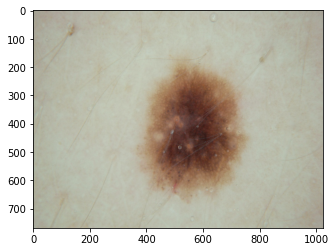

In [ ]:
img = mpimg.imread('data/Validation_Input/ISIC_0012585.jpg')
plt.imshow(img)
plt.show()

In [ ]:
import cv2
img_array = cv2.imread('data/Validation_Input/ISIC_0012585.jpg')
new_array = cv2.resize(img_array, (160, 160))
final_img = new_array.reshape(-1, 160, 160, 3)
prediction = model.predict([final_img])
print(prediction)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


In [ ]:
count_zeros = 0
for i in prediction:
  for j in i:
    if j[0] == 0:
      count_zeros += 1
  
print(count_zeros)

160


In [ ]:
print(prediction.shape)

(1, 160, 160, 1)


In [ ]:
from PIL import Image

data = np.reshape(prediction, (160, 160))
img = Image.fromarray(data, '1')
img.save('test2.png')
img.show()